In [1]:
import torch
import numpy as np
import math

class SeismicConfig:
    """Configuration class for seismic modeling"""
    def __init__(
        self,
        model_dims=(128, 128, 128),
        v0: float = 1500.0,  # Background velocity
        v_min: float = 1500.0,  # Minimum velocity
        v_max: float = 4500.0,  # Maximum velocity
        dv: float = 500.0,  # Velocity variation
        facies_type: str = "random"  # Type of seismic facies to generate
    ):
        self.model_dims = model_dims
        self.v0 = v0
        self.v_min = v_min
        self.v_max = v_max
        self.dv = dv
        self.facies_type = facies_type

        # Valid facies types
        self.valid_facies = [
            "parallel", "prograding", "fill", "hummocky",
            "chaotic", "divergent", "wave", "free", "random"
        ]

        if facies_type not in self.valid_facies:
            raise ValueError(f"Invalid facies type. Choose from: {', '.join(self.valid_facies)}")

def create_velocity_model(
    cfg: SeismicConfig,
    device: torch.device,
    seed: int = None):
    """
    Generates 3D velocity model with realistic geological features based on seismic facies

    Args:
        cfg: Configuration object containing model parameters
        device: Computation device (CPU/GPU)
        seed: Random seed for reproducibility (default: None)

    Returns:
        3D velocity tensor with shape (nx, ny, nz)
    """
    # Set random seed if provided
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    nx, ny, nz = cfg.model_dims

    # Choose facies type randomly if set to "random"
    facies_type = cfg.facies_type
    if facies_type == "random":
        facies_type = np.random.choice([f for f in cfg.valid_facies if f != "random"])

    # Create facies-specific velocity model
    facies_generators = {
        "parallel": create_parallel_subparallel_model,
        "prograding": create_prograding_clinoforms_model,
        "fill": create_fill_model,
        "hummocky": create_hummocky_model,
        "chaotic": create_chaotic_model,
        "divergent": create_divergent_model,
        "wave": create_wave_model,
        "free": create_free_model
    }

    velocity = facies_generators[facies_type](cfg, device)

    # Ensure velocity is within realistic bounds
    return torch.clamp(velocity, cfg.v_min, cfg.v_max)

def create_parallel_subparallel_model(cfg, device):
    """Creates a 3D velocity model with parallel/subparallel facies"""
    nx, ny, nz = cfg.model_dims
    velocity = torch.full(cfg.model_dims, cfg.v0, device=device)

    # Parameters for parallel layers
    num_layers = torch.randint(5, 15, (1,)).item()
    layer_thickness = nz // num_layers

    # Determine continuity, amplitude, and frequency characteristics
    continuity_type = np.random.choice(["excellent", "medium", "poor"])

    if continuity_type == "excellent":
        # High frequency, strong amplitude, excellent continuity
        amplitude_scale = 0.8
        frequency_scale = 4.0
        noise_scale = 0.05
    elif continuity_type == "medium":
        # Mid frequency, moderate amplitude, medium continuity
        amplitude_scale = 0.5
        frequency_scale = 2.5
        noise_scale = 0.15
    else:  # poor
        # Low frequency, weak amplitude, poor continuity
        amplitude_scale = 0.3
        frequency_scale = 1.5
        noise_scale = 0.25

    # Create base 2D pattern for parallel/subparallel layers
    for layer in range(num_layers):
        layer_start = layer * layer_thickness
        layer_end = (layer + 1) * layer_thickness

        # Base velocity for this layer
        base_vel = cfg.v0 + (layer % 3) * cfg.dv

        # Create slight undulations for subparallel effect
        X, Y = torch.meshgrid(
            torch.arange(nx, device=device),
            torch.arange(ny, device=device),
            indexing='ij'
        )

        undulation = amplitude_scale * 50 * torch.sin(
            2 * np.pi * frequency_scale * X / nx +
            2 * np.pi * frequency_scale * Y / ny
        )

        # Add noise based on continuity
        noise = torch.randn(nx, ny, device=device) * noise_scale * 50
        undulation += noise

        # Convert to integer offsets
        undulation = undulation.round().long()

        # Apply the layer with undulations
        for i in range(nx):
            for j in range(ny):
                offset = undulation[i, j].item()
                start = max(0, min(nz-1, layer_start + offset))
                end = max(0, min(nz, layer_end + offset))
                velocity[i, j, start:end] = base_vel

    # Add 3D variation by gradually changing the pattern along the y-axis
    for j in range(ny):
        # Slight modification factor that increases with y
        mod_factor = 1.0 + 0.2 * (j / ny)
        velocity[:, j, :] *= mod_factor

    return velocity

def create_prograding_clinoforms_model(cfg, device):
    """Creates a 3D velocity model with prograding clinoforms facies"""
    nx, ny, nz = cfg.model_dims
    velocity = torch.full(cfg.model_dims, cfg.v0, device=device)

    # Choose clinoform type
    clinoform_type = np.random.choice(["sigmoid", "oblique", "shingled", "parallel", "complex"])

    # Create coordinate grids for 2D slice
    X, Z = torch.meshgrid(
        torch.arange(nx, device=device),
        torch.arange(nz, device=device),
        indexing='ij'
    )

    # Number of clinoforms
    num_clinoforms = torch.randint(5, 12, (1,)).item()

    # Parameters for clinoform shape
    if clinoform_type == "sigmoid":
        # Sigmoid-shaped clinoforms
        for i in range(num_clinoforms):
            # Progradation direction (increasing x)
            x_shift = i * (nx // num_clinoforms)

            # Create sigmoid curve
            k = 0.15  # Steepness
            midpoint_z = nz // 2 + torch.randint(-nz//6, nz//6, (1,)).item()

            # Sigmoid function: 1/(1+exp(-k*(x-x0)))
            sigmoid = 1 / (1 + torch.exp(-k * (X - x_shift)))
            z_values = (sigmoid * nz * 0.6 + nz * 0.2).long()

            # Fill below the curve with higher velocity
            for x in range(nx):
                z_val = min(z_values[x, 0].item(), nz-1)
                velocity[x, :, z_val:] = cfg.v0 + cfg.dv

    elif clinoform_type == "oblique":
        # Oblique clinoforms (straight angled layers)
        slope = torch.rand(1, device=device).item() * 0.8 + 0.2  # Slope between 0.2 and 1.0

        for i in range(num_clinoforms):
            # Progradation direction
            x_shift = i * (nx // num_clinoforms)

            # Create oblique line
            for x in range(nx):
                z_val = int(slope * (x - x_shift) + nz // 4)
                if 0 <= z_val < nz:
                    # Fill below the line
                    velocity[x, :, z_val:] = cfg.v0 + cfg.dv * (i % 3 + 1)

    elif clinoform_type == "shingled":
        # Shingled clinoforms (overlapping thin layers)
        for i in range(num_clinoforms * 2):  # More layers for shingled appearance
            thickness = max(3, nz // 20)  # Thin layers
            slope = 0.5 + torch.rand(1, device=device).item() * 0.5
            x_shift = i * (nx // (num_clinoforms * 2))

            # Create shingled pattern
            for x in range(nx):
                z_top = int(slope * (x - x_shift) + nz // 4)
                if 0 <= z_top < nz:
                    z_bottom = min(z_top + thickness, nz)
                    velocity[x, :, z_top:z_bottom] = cfg.v0 + cfg.dv * (i % 3 + 1)

    elif clinoform_type == "parallel":
        # Parallel clinoforms (horizontal but prograding)
        for i in range(num_clinoforms):
            # Horizontal layers with progradation
            x_shift = i * (nx // num_clinoforms)
            layer_z = nz // 2 + i * (nz // (num_clinoforms * 2))

            if layer_z < nz:
                # Fill from this x position onward
                velocity[x_shift:, :, layer_z:] = cfg.v0 + cfg.dv * (i % 3 + 1)

    else:  # complex
        # Complex clinoforms (combination of patterns)
        # First create some sigmoid clinoforms
        for i in range(num_clinoforms // 2):
            x_shift = i * (nx // (num_clinoforms // 2))
            k = 0.1 + torch.rand(1, device=device).item() * 0.1
            sigmoid = 1 / (1 + torch.exp(-k * (X - x_shift)))
            z_values = (sigmoid * nz * 0.4 + nz * 0.3).long()

            for x in range(nx):
                z_val = min(z_values[x, 0].item(), nz-1)
                velocity[x, :, z_val:] = cfg.v0 + cfg.dv

        # Add some oblique components
        for i in range(num_clinoforms // 2, num_clinoforms):
            slope = torch.rand(1, device=device).item() * 0.5 + 0.3
            x_shift = i * (nx // num_clinoforms)

            for x in range(nx):
                z_val = int(slope * (x - x_shift) + nz // 3)
                if 0 <= z_val < nz:
                    thickness = max(5, nz // 15)
                    z_bottom = min(z_val + thickness, nz)
                    velocity[x, :, z_val:z_bottom] = cfg.v0 + cfg.dv * 1.5

    # Add 3D variation by gradually changing the pattern along the y-axis
    for j in range(ny):
        # Apply slight lateral shift to create 3D effect
        shift_amount = int(j * nx / (ny * 5))
        if shift_amount > 0:
            velocity[:, j, :] = torch.roll(velocity[:, j, :], shifts=shift_amount, dims=0)

    return velocity

def create_fill_model(cfg, device):
    """Creates a 3D velocity model with fill facies"""
    nx, ny, nz = cfg.model_dims
    velocity = torch.full(cfg.model_dims, cfg.v0, device=device)

    # Choose fill type
    fill_type = np.random.choice(["drape", "prograded", "mounded_onlap", "divergent", "chaotic", "complex"])

    # Create base basin shape
    X, Z = torch.meshgrid(
        torch.arange(nx, device=device),
        torch.arange(nz, device=device),
        indexing='ij'
    )

    # Create basin shape (U or V shaped)
    basin_center = nx // 2
    basin_width = nx * 0.7
    basin_depth = nz * 0.6

    if fill_type == "drape":
        # Drape fill (conformable layers over base)
        # Create U-shaped basin
        basin_shape = ((X - basin_center) / (basin_width/2))**2
        basin_shape = basin_shape * basin_depth
        basin_shape = basin_shape.clamp(0, nz-1).long()

        # Fill with conformable layers
        num_layers = torch.randint(4, 10, (1,)).item()
        for i in range(num_layers):
            layer_thickness = max(3, nz // (num_layers * 2))

            for x in range(nx):
                basin_bottom = basin_shape[x, 0].item()
                if basin_bottom < nz:
                    layer_bottom = min(nz-1, basin_bottom - i * layer_thickness)
                    layer_top = max(0, layer_bottom - layer_thickness)
                    velocity[x, :, layer_top:layer_bottom] = cfg.v0 + cfg.dv * (i % 3 + 1)

    elif fill_type == "prograded":
        # Prograded fill (layers building outward)
        # Create base basin shape
        basin_shape = ((X - basin_center) / (basin_width/2))**2
        basin_shape = basin_shape * basin_depth
        basin_shape = basin_shape.clamp(0, nz-1).long()

        # Create prograding fill
        num_steps = torch.randint(5, 12, (1,)).item()
        for i in range(num_steps):
            progradation_factor = i / num_steps
            modified_basin = basin_shape * (1 - progradation_factor * 0.8)

            for x in range(nx):
                basin_level = modified_basin[x, 0].item()
                if basin_level < nz:
                    velocity[x, :, basin_level:basin_level+5] = cfg.v0 + cfg.dv * (i % 3 + 1)

    elif fill_type == "mounded_onlap":
        # Mounded onlap fill
        # Create base basin shape
        basin_shape = ((X - basin_center) / (basin_width/2))**2
        basin_shape = basin_shape * basin_depth
        basin_shape = basin_shape.clamp(0, nz-1).long()

        # Create mounded layers
        num_mounds = torch.randint(3, 7, (1,)).item()
        for i in range(num_mounds):
            mound_center = torch.randint(nx//4, 3*nx//4, (1,)).item()
            mound_width = nx // (num_mounds + 1)
            mound_height = nz // (num_mounds + 2)

            # Create mound shape
            for x in range(nx):
                dist_from_center = abs(x - mound_center)
                if dist_from_center < mound_width:
                    # Mound shape (semi-elliptical)
                    height_factor = math.sqrt(1 - (dist_from_center/mound_width)**2)
                    mound_z = basin_shape[x, 0].item() - int(height_factor * mound_height)
                    if mound_z >= 0:
                        velocity[x, :, mound_z:basin_shape[x, 0].item()] = cfg.v0 + cfg.dv * (i % 3 + 1)

    elif fill_type == "divergent":
        # Divergent fill (layers thickening toward center)
        # Create base basin shape
        basin_shape = ((X - basin_center) / (basin_width/2))**2
        basin_shape = basin_shape * basin_depth
        basin_shape = basin_shape.clamp(0, nz-1).long()

        # Create divergent layers
        num_layers = torch.randint(5, 10, (1,)).item()
        for i in range(num_layers):
            layer_factor = (num_layers - i) / num_layers

            for x in range(nx):
                # Calculate thickness based on position (thicker in center)
                rel_pos = 1.0 - abs(2 * (x - basin_center) / nx)
                thickness = max(2, int(rel_pos * nz * 0.1 * layer_factor))

                basin_bottom = basin_shape[x, 0].item()
                layer_bottom = min(nz-1, basin_bottom - i * 5)
                layer_top = max(0, layer_bottom - thickness)

                if layer_top < layer_bottom:
                    velocity[x, :, layer_top:layer_bottom] = cfg.v0 + cfg.dv * (i % 3 + 1)

    elif fill_type == "chaotic":
        # Chaotic fill
        # Create base basin shape
        basin_shape = ((X - basin_center) / (basin_width/2))**2
        basin_shape = basin_shape * basin_depth
        basin_shape = basin_shape.clamp(0, nz-1).long()

        # Fill basin with chaotic pattern
        for x in range(nx):
            basin_bottom = basin_shape[x, 0].item()
            if basin_bottom > 0:
                # Create chaotic velocity pattern
                chaotic_fill = torch.randn(basin_bottom, device=device) * cfg.dv * 0.5 + cfg.v0 + cfg.dv
                velocity[x, :, :basin_bottom] = chaotic_fill.unsqueeze(0).expand(ny, -1)

    else:  # complex
        # Complex fill (combination of patterns)
        # Create base basin shape
        basin_shape = ((X - basin_center) / (basin_width/2))**2
        basin_shape = basin_shape * basin_depth
        basin_shape = basin_shape.clamp(0, nz-1).long()

        # Add some mounded features
        num_mounds = torch.randint(2, 5, (1,)).item()
        for i in range(num_mounds):
            mound_center = torch.randint(nx//4, 3*nx//4, (1,)).item()
            mound_width = nx // 6
            mound_height = nz // 8

            for x in range(nx):
                dist_from_center = abs(x - mound_center)
                if dist_from_center < mound_width:
                    height_factor = math.sqrt(1 - (dist_from_center/mound_width)**2)
                    mound_z = basin_shape[x, 0].item() - int(height_factor * mound_height)
                    if mound_z >= 0:
                        velocity[x, :, mound_z:basin_shape[x, 0].item()] = cfg.v0 + cfg.dv * 2

        # Add some chaotic regions
        for x in range(nx):
            if torch.rand(1).item() < 0.3:  # 30% chance of chaotic section
                basin_bottom = basin_shape[x, 0].item()
                if basin_bottom > nz // 3:
                    chaotic_top = torch.randint(0, basin_bottom, (1,)).item()
                    chaotic_height = min(basin_bottom - chaotic_top, nz // 5)
                    chaotic_fill = torch.randn(chaotic_height, device=device) * cfg.dv * 0.5 + cfg.v0 + cfg.dv
                    velocity[x, :, chaotic_top:chaotic_top+chaotic_height] = chaotic_fill.unsqueeze(0).expand(ny, -1)

    # Add 3D variation by gradually changing the pattern along the y-axis
    for j in range(ny):
        # Modify basin shape slightly along y-axis
        y_factor = 1.0 + 0.2 * math.sin(2 * math.pi * j / ny)
        velocity[:, j, :] = torch.roll(velocity[:, j, :], shifts=int(j * nx / (ny * 10)), dims=0)
        # Scale velocities slightly
        velocity[:, j, :] = velocity[:, j, :] * y_factor

    return velocity

def create_hummocky_model(cfg, device):
    """Creates a 3D velocity model with hummocky facies"""
    nx, ny, nz = cfg.model_dims
    velocity = torch.full(cfg.model_dims, cfg.v0, device=device)

    # Choose hummocky type
    hummocky_type = np.random.choice(["fan_complex", "mound", "slumping", "chaotic"])

    # Create coordinate grids for 2D slice
    X, Z = torch.meshgrid(
        torch.arange(nx, device=device),
        torch.arange(nz, device=device),
        indexing='ij'
    )

    if hummocky_type == "fan_complex":
        # Fan complex hummocky pattern
        num_fans = torch.randint(2, 5, (1,)).item()

        for i in range(num_fans):
            # Fan apex position
            fan_x = torch.randint(nx//5, 4*nx//5, (1,)).item()
            fan_z = torch.randint(nz//5, 4*nz//5, (1,)).item()

            # Fan parameters
            fan_width = nx // 3
            fan_height = nz // 4
            fan_angle = torch.rand(1).item() * math.pi * 0.6 - math.pi * 0.3  # -30 to +30 degrees

            # Create fan shape
            for x in range(nx):
                dx = x - fan_x
                # Distance from fan apex
                dist = abs(dx)
                if dist < fan_width:
                    # Calculate fan depth at this x position
                    angle_factor = math.cos(fan_angle) if dx > 0 else math.cos(fan_angle + math.pi)
                    depth = fan_z + int(dist * math.tan(fan_angle))

                    # Fan thickness increases with distance from apex
                    thickness = max(3, int(dist / fan_width * fan_height))

                    # Ensure within bounds
                    if 0 <= depth < nz:
                        top = max(0, depth - thickness // 2)
                        bottom = min(nz, depth + thickness // 2)
                        velocity[x, :, top:bottom] = cfg.v0 + cfg.dv * (i % 3 + 1)

    elif hummocky_type == "mound":
        # Mound hummocky pattern
        num_mounds = torch.randint(4, 10, (1,)).item()

        for i in range(num_mounds):
            # Mound position
            mound_x = torch.randint(0, nx, (1,)).item()
            mound_z = torch.randint(nz//3, 2*nz//3, (1,)).item()

            # Mound size
            mound_width = torch.randint(nx//10, nx//5, (1,)).item()
            mound_height = torch.randint(nz//15, nz//8, (1,)).item()

            # Create mound shape (semi-elliptical)
            for x in range(max(0, mound_x-mound_width), min(nx, mound_x+mound_width)):
                rel_x = (x - mound_x) / mound_width
                if abs(rel_x) <= 1:
                    height_factor = math.sqrt(1 - rel_x**2)
                    mound_top = max(0, mound_z - int(height_factor * mound_height))
                    velocity[x, :, mound_top:mound_z] = cfg.v0 + cfg.dv * (i % 3 + 1)

    elif hummocky_type == "slumping":
        # Slumping hummocky pattern
        num_slumps = torch.randint(3, 7, (1,)).item()

        # Base horizon
        base_z = nz // 2
        velocity[:, :, base_z:] = cfg.v0 + cfg.dv

        for i in range(num_slumps):
            # Slump position and size
            slump_start = torch.randint(0, nx//2, (1,)).item()
            slump_end = torch.randint(slump_start + nx//4, nx, (1,)).item()
            slump_depth = torch.randint(nz//10, nz//5, (1,)).item()

            # Create slumping pattern
            for x in range(slump_start, slump_end):
                # Calculate deformation based on position in slump
                rel_pos = (x - slump_start) / (slump_end - slump_start)
                # Sine wave deformation
                deform = int(slump_depth * math.sin(rel_pos * math.pi))

                # Apply deformation to base horizon
                deformed_z = min(nz-1, base_z + deform)
                velocity[x, :, deformed_z:] = cfg.v0 + cfg.dv * 1.5

                # Add internal deformation structures
                if torch.rand(1).item() < 0.7:  # 70% chance
                    internal_z = base_z + deform // 2
                    thickness = max(2, deform // 3)
                    velocity[x, :, internal_z:internal_z+thickness] = cfg.v0 + cfg.dv * 0.8

    else:  # chaotic
        # Chaotic hummocky pattern
        base_z = nz // 2

        # Create chaotic base with hummocky elements
        for x in range(nx):
            # Random base level variations
            base_variation = torch.randint(-nz//10, nz//10, (1,)).item()
            local_base = base_z + base_variation

            # Add chaotic velocity variations
            for z in range(max(0, local_base - nz//5), min(nz, local_base + nz//5)):
                if torch.rand(1).item() < 0.7:  # 70% chance of anomaly
                    anomaly_strength = torch.rand(1).item() * cfg.dv * 2
                    velocity[x, :, z] = cfg.v0 + anomaly_strength

    # Add 3D variation by gradually changing the pattern along the y-axis
    for j in range(ny):
        # Apply slight modifications to create 3D effect
        if j > 0:
            # Blend with previous slice with some random variations
            blend_factor = 0.8
            noise_factor = 0.2
            prev_slice = velocity[:, j-1, :].clone()
            curr_slice = velocity[:, j, :].clone()

            # Add random noise
            noise = torch.randn_like(curr_slice) * cfg.dv * noise_factor

            # Blend slices
            velocity[:, j, :] = blend_factor * prev_slice + (1 - blend_factor) * curr_slice + noise

    return velocity

def create_chaotic_model(cfg, device):
    """Creates a 3D velocity model with chaotic facies"""
    nx, ny, nz = cfg.model_dims
    velocity = torch.full(cfg.model_dims, cfg.v0, device=device)

    # Choose chaotic type
    chaotic_type = np.random.choice(["discontinuous", "discordant", "short_strong"])

    if chaotic_type == "discontinuous":
        # Discontinuous chaotic pattern
        # Create base layers
        num_layers = torch.randint(5, 15, (1,)).item()
        layer_thickness = nz // num_layers

        for layer in range(num_layers):
            layer_start = layer * layer_thickness
            layer_end = (layer + 1) * layer_thickness
            layer_vel = cfg.v0 + (layer % 3) * cfg.dv

            # Fill layer with base velocity
            velocity[:, :, layer_start:layer_end] = layer_vel

        # Add discontinuities
        num_breaks = torch.randint(nx//5, nx//2, (1,)).item()
        for _ in range(num_breaks):
            break_x = torch.randint(0, nx, (1,)).item()
            break_width = torch.randint(1, max(2, nx//20), (1,)).item()

            # Create vertical discontinuity
            for x in range(max(0, break_x-break_width), min(nx, break_x+break_width)):
                # Random chaotic velocities
                chaotic_vel = torch.rand(nz, device=device) * cfg.dv * 2 + cfg.v0
                velocity[x, :, :] = chaotic_vel.unsqueeze(0).expand(ny, -1)

    elif chaotic_type == "discordant":
        # Discordant chaotic pattern (crossing patterns)
        # Create some base diagonal trends
        num_trends = torch.randint(3, 8, (1,)).item()

        for i in range(num_trends):
            # Random start and end points
            x1 = torch.randint(0, nx//2, (1,)).item()
            z1 = torch.randint(0, nz, (1,)).item()
            x2 = torch.randint(nx//2, nx, (1,)).item()
            z2 = torch.randint(0, nz, (1,)).item()

            # Trend thickness
            thickness = torch.randint(3, max(4, nz//15), (1,)).item()
            trend_vel = cfg.v0 + cfg.dv * (i % 3 + 1)

            # Draw diagonal trend
            for x in range(nx):
                if x1 != x2:  # Avoid division by zero
                    # Linear interpolation
                    z = z1 + (z2 - z1) * (x - x1) / (x2 - x1)
                    z = int(z)

                    # Fill around the trend line
                    for dz in range(-thickness//2, thickness//2 + 1):
                        curr_z = z + dz
                        if 0 <= curr_z < nz:
                            velocity[x, :, curr_z] = trend_vel

        # Add random chaotic patches
        num_patches = torch.randint(5, 15, (1,)).item()
        for _ in range(num_patches):
            patch_x = torch.randint(0, nx, (1,)).item()
            patch_z = torch.randint(0, nz, (1,)).item()
            patch_size_x = torch.randint(5, max(6, nx//10), (1,)).item()
            patch_size_z = torch.randint(5, max(6, nz//10), (1,)).item()

            # Fill patch with random velocities
            for x in range(max(0, patch_x-patch_size_x//2), min(nx, patch_x+patch_size_x//2)):
                for z in range(max(0, patch_z-patch_size_z//2), min(nz, patch_z+patch_size_z//2)):
                    velocity[x, :, z] = cfg.v0 + torch.rand(1, device=device).item() * cfg.dv * 2

    else:  # short_strong
        # Short and strong reflection pattern
        # Create background with weak reflections
        for z in range(0, nz, nz//20):
            thickness = max(1, nz//40)
            velocity[:, :, z:z+thickness] = cfg.v0 + cfg.dv * 0.5

        # Add short, strong reflections
        num_reflections = torch.randint(20, 50, (1,)).item()
        for _ in range(num_reflections):
            # Random position
            x = torch.randint(0, nx, (1,)).item()
            z = torch.randint(0, nz, (1,)).item()

            # Random size (short)
            length = torch.randint(5, max(6, nx//8), (1,)).item()
            thickness = torch.randint(2, 5, (1,)).item()

            # Random orientation
            horizontal = torch.rand(1).item() < 0.5

            # Strong velocity contrast
            reflection_vel = cfg.v0 + cfg.dv * 2.5

            if horizontal:
                # Horizontal reflection
                for dx in range(-length//2, length//2):
                    curr_x = x + dx
                    if 0 <= curr_x < nx:
                        for dz in range(thickness):
                            curr_z = z + dz
                            if 0 <= curr_z < nz:
                                velocity[curr_x, :, curr_z] = reflection_vel
            else:
                # Vertical reflection
                for dz in range(-length//2, length//2):
                    curr_z = z + dz
                    if 0 <= curr_z < nz:
                        for dx in range(thickness):
                            curr_x = x + dx
                            if 0 <= curr_x < nx:
                                velocity[curr_x, :, curr_z] = reflection_vel

    # Add 3D variation by gradually changing the pattern along the y-axis
    for j in range(ny):
        # Add random noise that increases with y
        noise_level = 0.1 + 0.2 * (j / ny)
        noise = torch.randn(nx, nz, device=device) * noise_level * cfg.dv
        velocity[:, j, :] += noise

        # Occasionally add chaotic patches in 3D
        if j % 5 == 0:
            patch_x = torch.randint(0, nx, (1,)).item()
            patch_z = torch.randint(0, nz, (1,)).item()
            patch_size = torch.randint(5, max(6, nx//10), (1,)).item()

            for x in range(max(0, patch_x-patch_size), min(nx, patch_x+patch_size)):
                for z in range(max(0, patch_z-patch_size), min(nz, patch_z+patch_size)):
                    velocity[x, j, z] = cfg.v0 + torch.rand(1, device=device).item() * cfg.dv * 2

    return velocity

def create_divergent_model(cfg, device):
    """Creates a 3D velocity model with divergent facies"""
    nx, ny, nz = cfg.model_dims
    velocity = torch.full(cfg.model_dims, cfg.v0, device=device)

    # Create coordinate grids for 2D slice
    X, Z = torch.meshgrid(
        torch.arange(nx, device=device),
        torch.arange(nz, device=device),
        indexing='ij'
    )

    # Create divergent pattern (layers thickening away from center)
    center_x = nx // 2
    num_layers = torch.randint(5, 15, (1,)).item()

    # Create base layer
    base_z = nz * 3 // 4
    velocity[:, :, base_z:] = cfg.v0 + cfg.dv

    for i in range(num_layers):
        # Layer parameters
        layer_vel = cfg.v0 + cfg.dv * ((i % 3) + 0.5)

        # Create divergent layer (thicker away from center)
        for x in range(nx):
            # Calculate distance from center
            dist_from_center = abs(x - center_x)

            # Layer thickness increases with distance from center
            thickness_factor = dist_from_center / (nx / 2)
            base_thickness = max(2, nz // (num_layers * 2))
            thickness = int(base_thickness * (1 + thickness_factor * 2))

            # Layer position
            layer_top = max(0, base_z - (i + 1) * base_thickness - int(thickness_factor * i * base_thickness))
            layer_bottom = min(nz, layer_top + thickness)

            # Set velocity for this layer
            velocity[x, :, layer_top:layer_bottom] = layer_vel

    # Add 3D variation by gradually changing the pattern along the y-axis
    for j in range(ny):
        # Shift center position slightly along y-axis
        center_shift = int((j - ny/2) * nx / (ny * 5))
        if center_shift != 0:
            velocity[:, j, :] = torch.roll(velocity[:, j, :], shifts=center_shift, dims=0)

        # Add slight velocity variations
        mod_factor = 1.0 + 0.1 * math.sin(2 * math.pi * j / ny)
        velocity[:, j, :] *= mod_factor

    return velocity

def create_wave_model(cfg, device):
    """Creates a 3D velocity model with wave facies"""
    nx, ny, nz = cfg.model_dims
    velocity = torch.full(cfg.model_dims, cfg.v0, device=device)

    # Create coordinate grids for 2D slice
    X, Z = torch.meshgrid(
        torch.arange(nx, device=device),
        torch.arange(nz, device=device),
        indexing='ij'
    )

    # Wave parameters
    num_waves = torch.randint(3, 7, (1,)).item()
    wave_amplitude = nz // 15

    # Base layer position
    base_z = nz // 2

    # Create wavy layers
    for i in range(num_waves):
        # Wave frequency
        frequency = (i + 1) * 2 * math.pi / nx
        phase = torch.rand(1, device=device).item() * 2 * math.pi

        # Create wave pattern
        for x in range(nx):
            # Calculate wave position
            wave_z = base_z + int(wave_amplitude * math.sin(frequency * x + phase))

            # Layer thickness
            thickness = max(3, nz // 20)

            # Set velocity for this wavy layer
            layer_top = max(0, wave_z - thickness // 2)
            layer_bottom = min(nz, wave_z + thickness // 2)
            velocity[x, :, layer_top:layer_bottom] = cfg.v0 + cfg.dv * (i % 3 + 1)

    # Add 3D variation by gradually changing the pattern along the y-axis
    for j in range(ny):
        # Add phase shift along y-axis
        phase_shift = 2 * math.pi * j / ny

        # Create wave pattern with phase shift
        for i in range(num_waves):
            frequency = (i + 1) * 2 * math.pi / nx
            phase = torch.rand(1, device=device).item() * 2 * math.pi + phase_shift

            for x in range(nx):
                wave_z = base_z + int(wave_amplitude * math.sin(frequency * x + phase))
                thickness = max(3, nz // 20)

                layer_top = max(0, wave_z - thickness // 2)
                layer_bottom = min(nz, wave_z + thickness // 2)
                velocity[x, j, layer_top:layer_bottom] = cfg.v0 + cfg.dv * (i % 3 + 1)

    return velocity

def create_free_model(cfg, device):
    """Creates a 3D velocity model with reflection-free facies"""
    nx, ny, nz = cfg.model_dims

    # For reflection-free, we create a mostly homogeneous model with very subtle variations

    # Base velocity with small random variations
    base_vel = cfg.v0 + torch.rand(1, device=device).item() * cfg.dv * 0.3
    velocity = torch.full(cfg.model_dims, base_vel, device=device)

    # Add very subtle random noise (much lower amplitude than other facies)
    noise = torch.randn(cfg.model_dims, device=device) * cfg.dv * 0.05
    velocity += noise

    # Occasionally add very faint, large-scale trends
    if torch.rand(1).item() < 0.5:
        # Gradual vertical trend
        for z in range(nz):
            factor = 1.0 + 0.05 * (z / nz)
            velocity[:, :, z] *= factor

    # Add 3D variation (very subtle)
    for j in range(ny):
        # Almost imperceptible variations along y
        factor = 1.0 + 0.02 * math.sin(2 * math.pi * j / ny)
        velocity[:, j, :] *= factor

    return velocity



In [2]:
def visualize_velocity_model(velocity, title="Velocity Model"):
    """
    Visualize a 3D velocity model with slices along each axis

    Args:
        velocity: 3D velocity tensor
        title: Plot title
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # Convert to numpy for plotting
    if torch.is_tensor(velocity):
        velocity = velocity.cpu().numpy()

    nx, ny, nz = velocity.shape

    # Create slices at the center of each dimension
    slice_x = velocity[nx//2, :, :]
    slice_y = velocity[:, ny//2, :]
    slice_z = velocity[:, :, nz//2]

    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot slices
    im0 = axes[0].imshow(slice_x.T, cmap='viridis', aspect='auto')
    axes[0].set_title(f'X Slice (x={nx//2})')
    axes[0].set_xlabel('Y')
    axes[0].set_ylabel('Z')

    im1 = axes[1].imshow(slice_y.T, cmap='viridis', aspect='auto')
    axes[1].set_title(f'Y Slice (y={ny//2})')
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Z')

    im2 = axes[2].imshow(slice_z, cmap='viridis', aspect='auto')
    axes[2].set_title(f'Z Slice (z={nz//2})')
    axes[2].set_xlabel('X')
    axes[2].set_ylabel('Y')

    # Add colorbars
    for i, ax in enumerate(axes):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar([im0, im1, im2][i], cax=cax)

    plt.suptitle(f"{title} - Velocity (m/s)")
    plt.tight_layout()
    plt.show()

def example_usage():
    """Example of how to use the seismic facies model generators"""
    import torch

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create smaller models for demonstration
    model_dims = (64, 64, 64)

    # Test each facies type
    for facies_type in ["parallel", "prograding", "fill", "hummocky",
                        "chaotic", "divergent", "wave", "free"]:
        print(f"Generating {facies_type} facies model...")

        # Create configuration
        cfg = SeismicConfig(
            model_dims=model_dims,
            v0=1500.0,
            v_min=1500.0,
            v_max=4500.0,
            dv=500.0,
            facies_type=facies_type
        )

        # Generate velocity model
        velocity = create_velocity_model(cfg, device, seed=42)

        # Visualize
        visualize_velocity_model(velocity, title=f"{facies_type.capitalize()} Facies")


Generating parallel facies model...


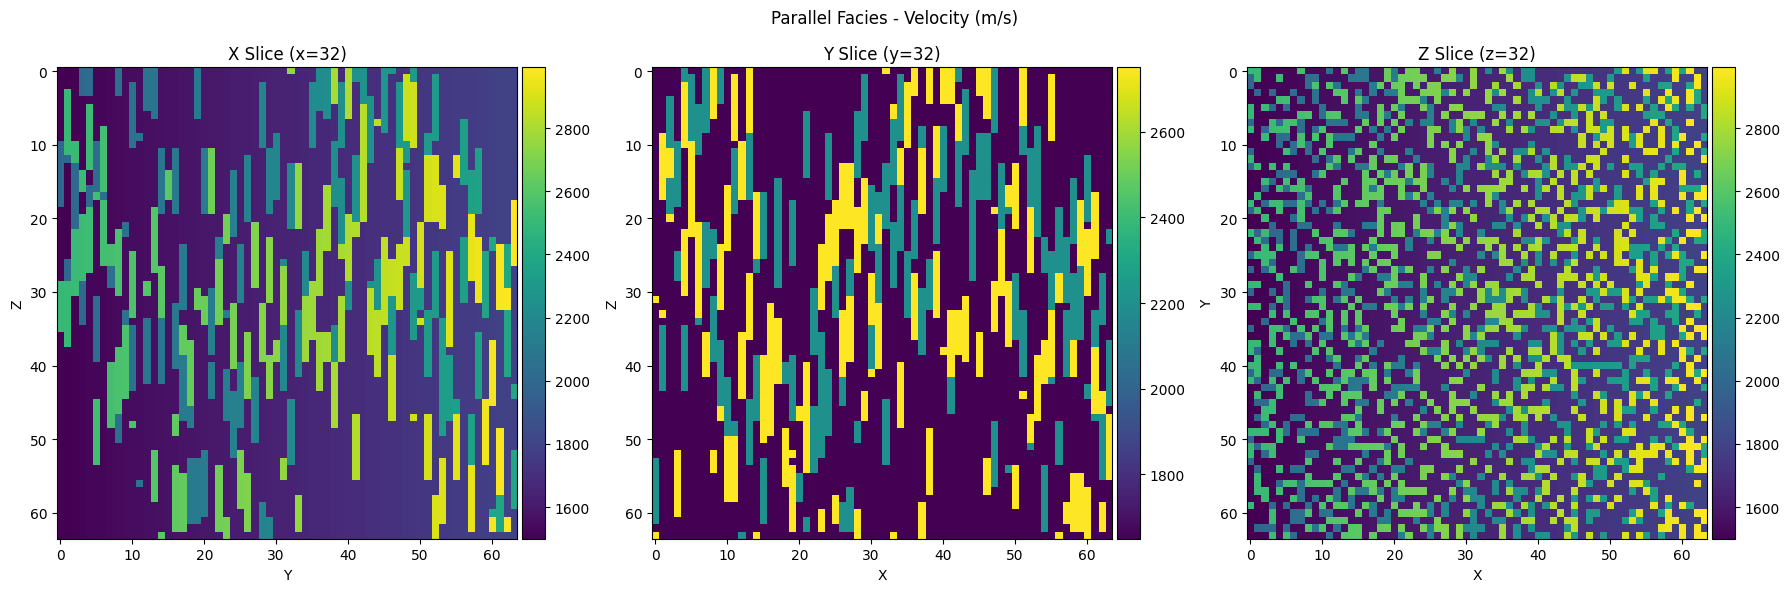

Generating prograding facies model...


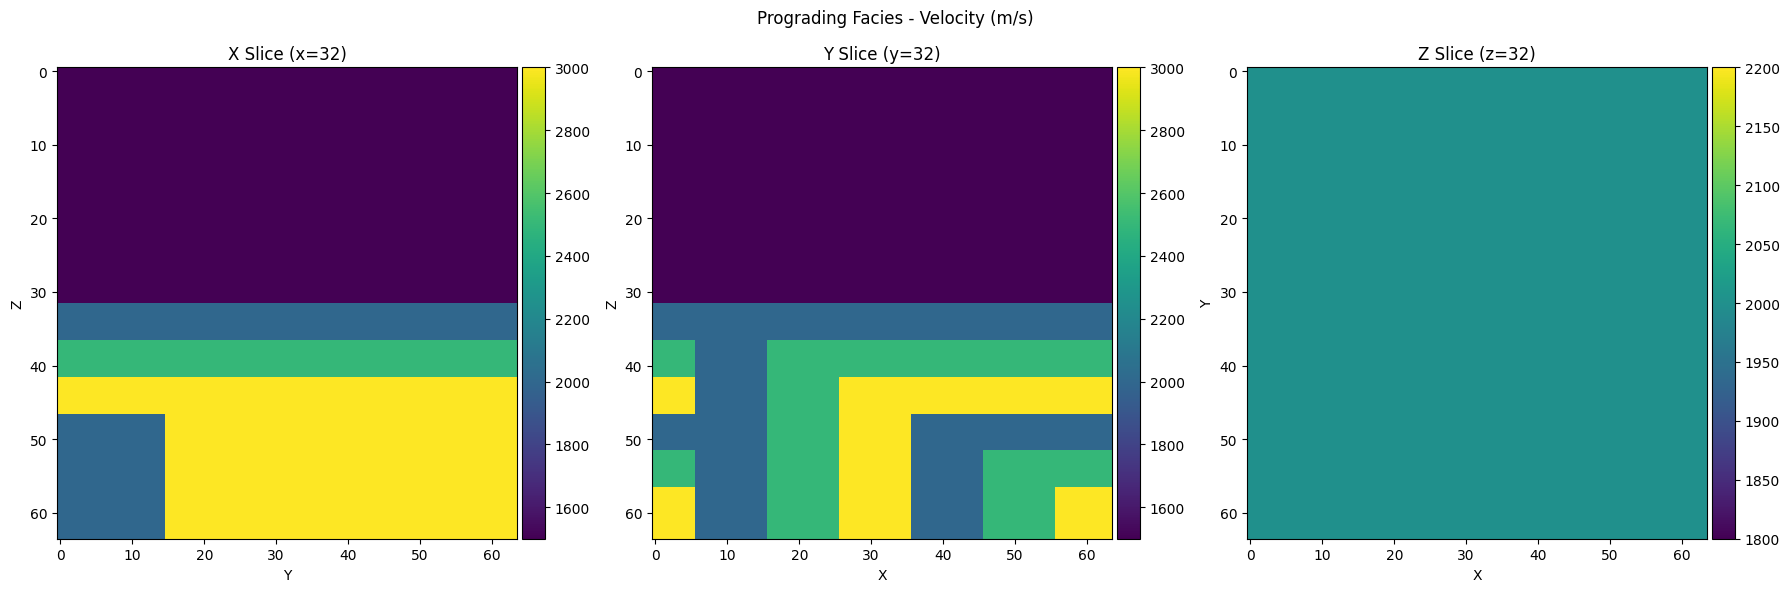

Generating fill facies model...


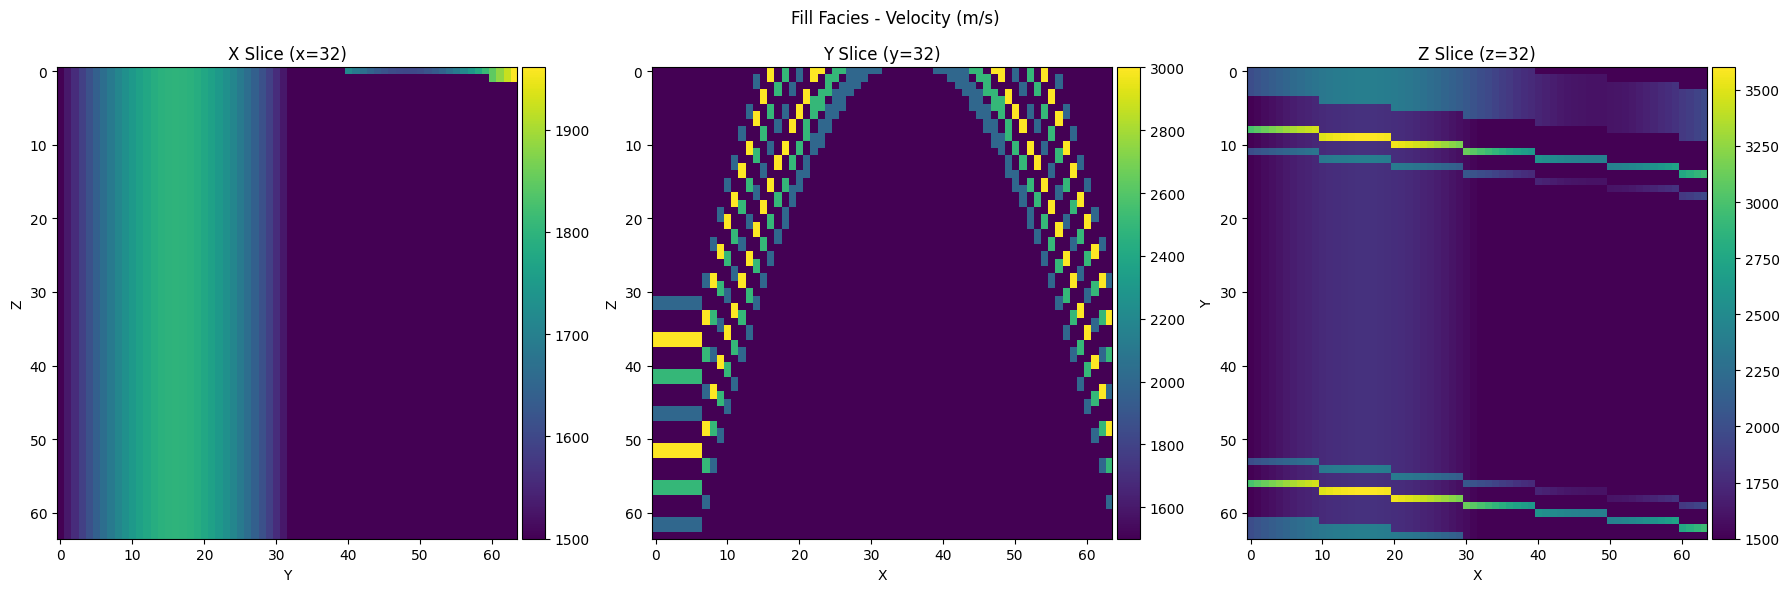

Generating hummocky facies model...


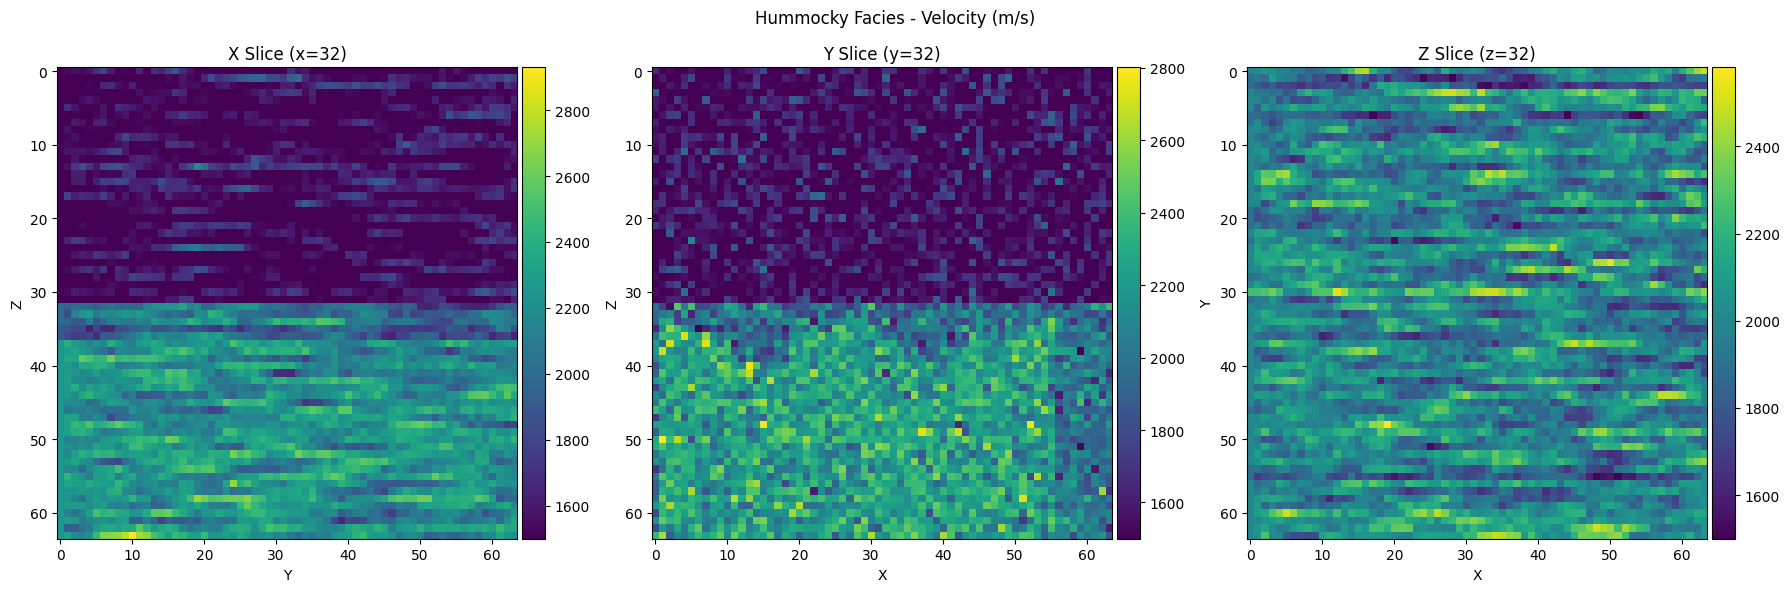

Generating chaotic facies model...


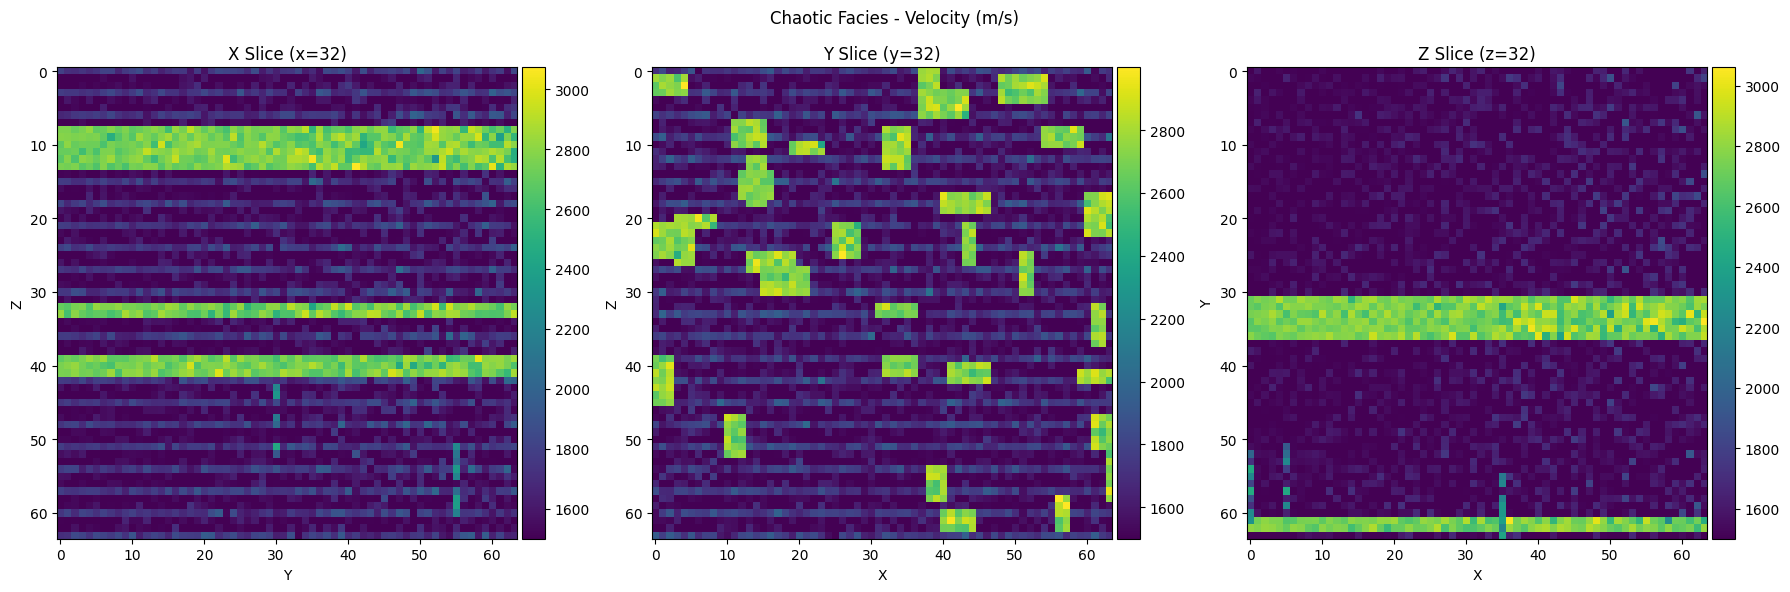

Generating divergent facies model...


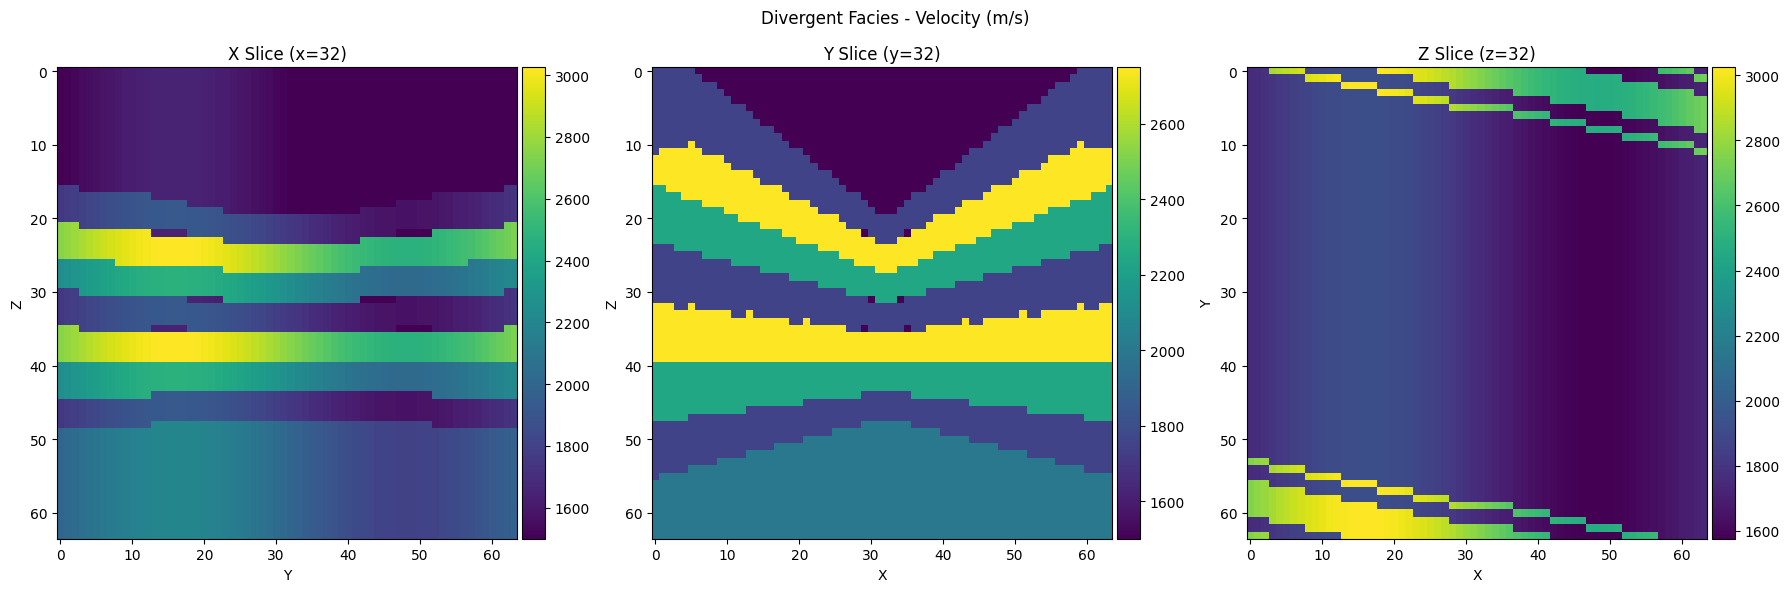

Generating wave facies model...


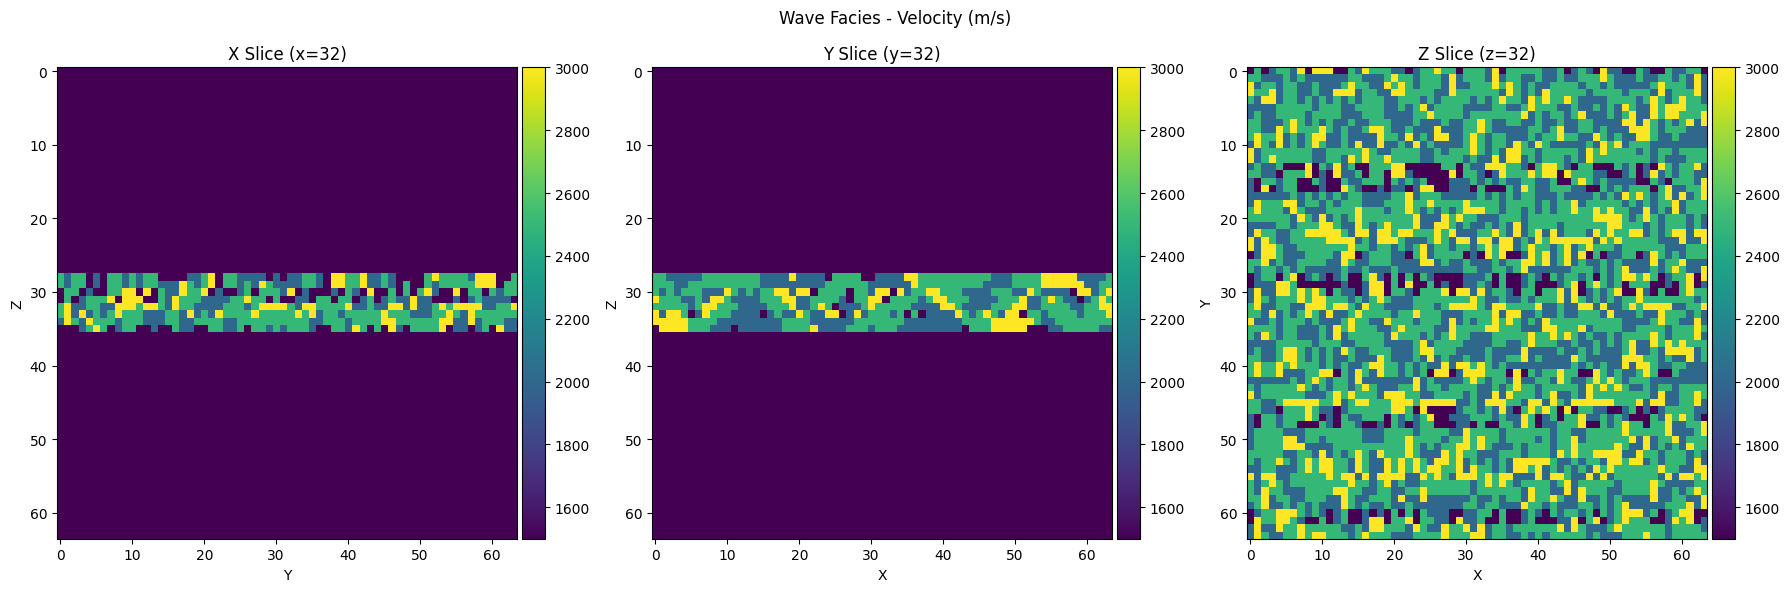

Generating free facies model...


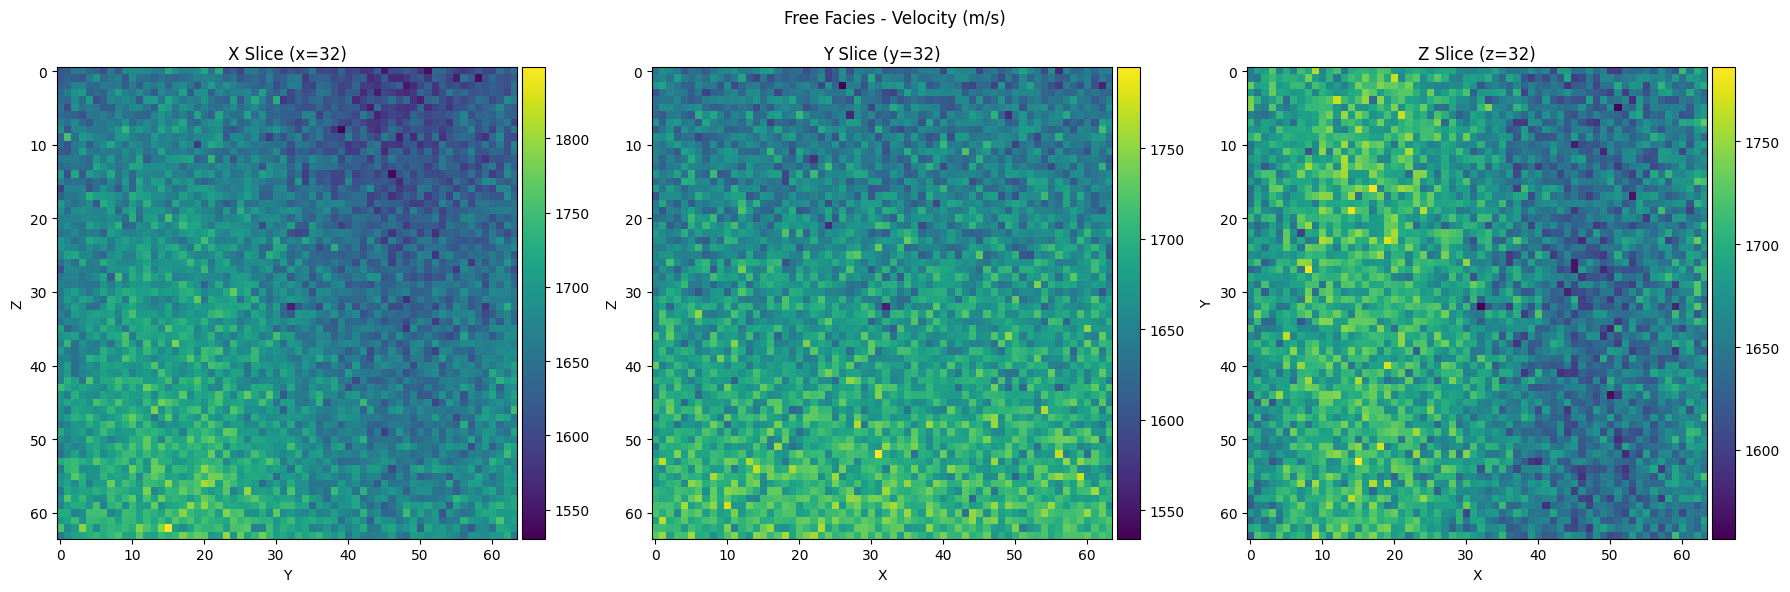

In [3]:
example_usage()